In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from evaluation.integrate_scattered_field import compute_integrated_values, plot_integration_subplots,plot_epsilon
from utils.DataInterface import DataInterface
from models.sSnomModel import sSnomModel

data_iface = DataInterface()

project_root = data_iface.find_project_root()
chen_data_path = project_root / "data/Chen2021"


def nk_to_eps(n, k):
    """
    Convert refractive index (n) and extinction coefficient (k)
    to complex dielectric permittivity: eps = (n^2 - k^2) + i(2*n*k)
    """
    eps1 = n**2-k**2
    eps2 = 2*n*k
    return eps1, eps2

Project Root: /Users/lugarini/Documents/nano-optics-ml
Data Directory: /Users/lugarini/Documents/nano-optics-ml/data

Contents of the main data directory:
- .DS_Store (File)
- Chen2021 (Dir)
- NanoFTIR (Dir)


In [13]:


data = np.genfromtxt(chen_data_path/'Au_nk.csv', delimiter = ',')
f = data[:,0]
f_Au = np.linspace(1000, 1200,500)
n = np.interp(f_Au, f, data[:,1])
k = np.interp(f_Au, f, data[:,2])
eps1, eps2 = nk_to_eps(n,k)
eps_Au = eps1 + 1j*eps2

integrated_values = compute_integrated_values(f_Au, [2], 2*np.pi*250e3, eps_Au)

au_mean_S2 = np.mean(integrated_values)

In [14]:
from models.permittivity import compute_permittivity



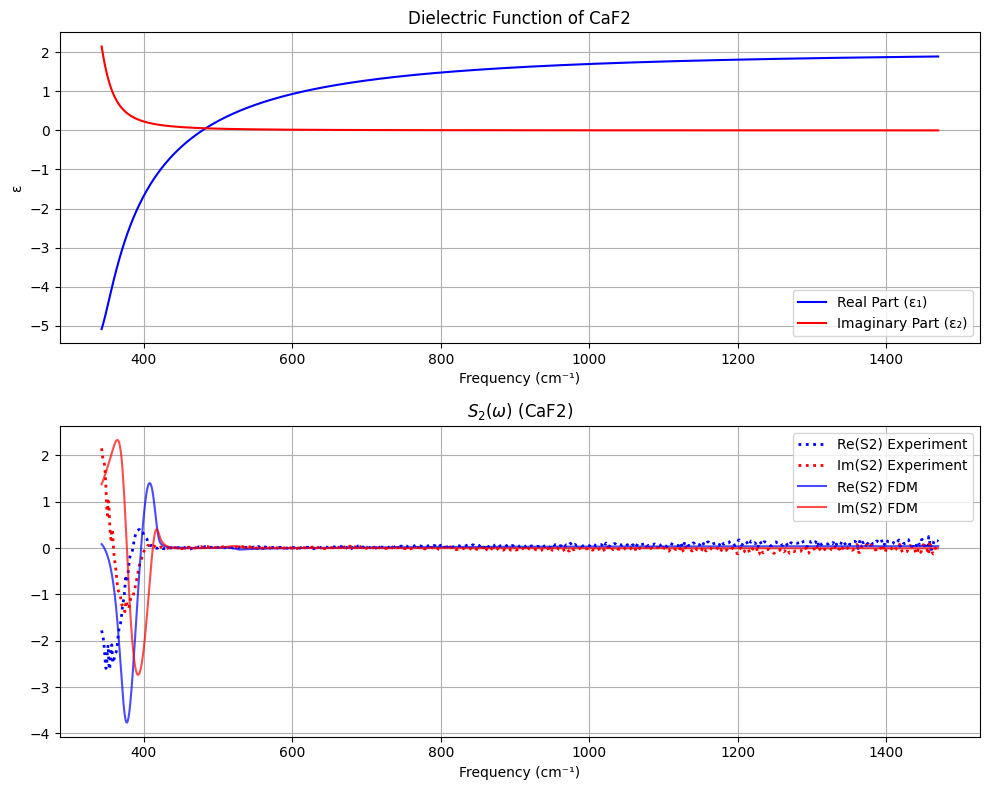

In [15]:
material = 'CaF2'
material_path = chen_data_path / f'{material}_eff.csv'

material_raw_data = np.genfromtxt(
    material_path,
    delimiter=','
    )
eps_material = material_raw_data[:,0] + 1j*material_raw_data[:,1]
Sn_material = material_raw_data[:,2] + 1j*material_raw_data[:,3]
f_material = material_raw_data[:,4]
eps_material = compute_permittivity(f_material, 'CaF2')

integrated_values_material = compute_integrated_values(f_material, [2], 2*np.pi*250e3, eps_material)
normalized_integrated_values = integrated_values_material/au_mean_S2

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

plot_epsilon(f_material, eps_material, material, '', ax[0])

ax[1].plot(f_material, Sn_material.real, label= 'Re(S2) Experiment',color='b', linestyle='dotted', linewidth=2)
ax[1].plot(f_material, Sn_material.imag, label= 'Im(S2) Experiment', color='r', linestyle='dotted', linewidth=2)

ax[1].plot(f_material, normalized_integrated_values.real, label= 'Re(S2) FDM',color='b', alpha=0.7)
ax[1].plot(f_material, normalized_integrated_values.imag, label= 'Im(S2) FDM', color='r', alpha=0.7)
ax[1].set_xlabel('Frequency (cm⁻¹)')
ax[1].set_title(f'$S_2(\\omega)$ ({material})')
ax[1].legend()
ax[1].grid(True)

fig.tight_layout()

In [16]:
from models.permittivity import compute_permittivity

materials_list = ['STO', 'SiO2','NGO','CaF2', 'LSAT', 'GaAs']

main_data_dict = dict()

for i, material in enumerate(materials_list):
    inner_dict = dict()
    material_path = chen_data_path / f'{material}_eff.csv'

    material_raw_data = np.genfromtxt(
        material_path,
        delimiter=','
        )
    
    eps_material = material_raw_data[:,0] + 1j*material_raw_data[:,1]
    Sn_material = material_raw_data[:,2] + 1j*material_raw_data[:,3]
    f_material = material_raw_data[:,4]
    if material == 'CaF2':
        eps_material = compute_permittivity(f_material, 'CaF2')

    integrated_values_material = compute_integrated_values(f_material, [2], 2*np.pi*250e3, eps_material)
    normalized_integrated_values = integrated_values_material/au_mean_S2

    inner_dict['eps']  = eps_material
    inner_dict['Sn_exp']  = Sn_material
    inner_dict['f']  = f_material
    inner_dict['Sn_fdm_normalized']  = normalized_integrated_values
    
    main_data_dict[material] = inner_dict
    

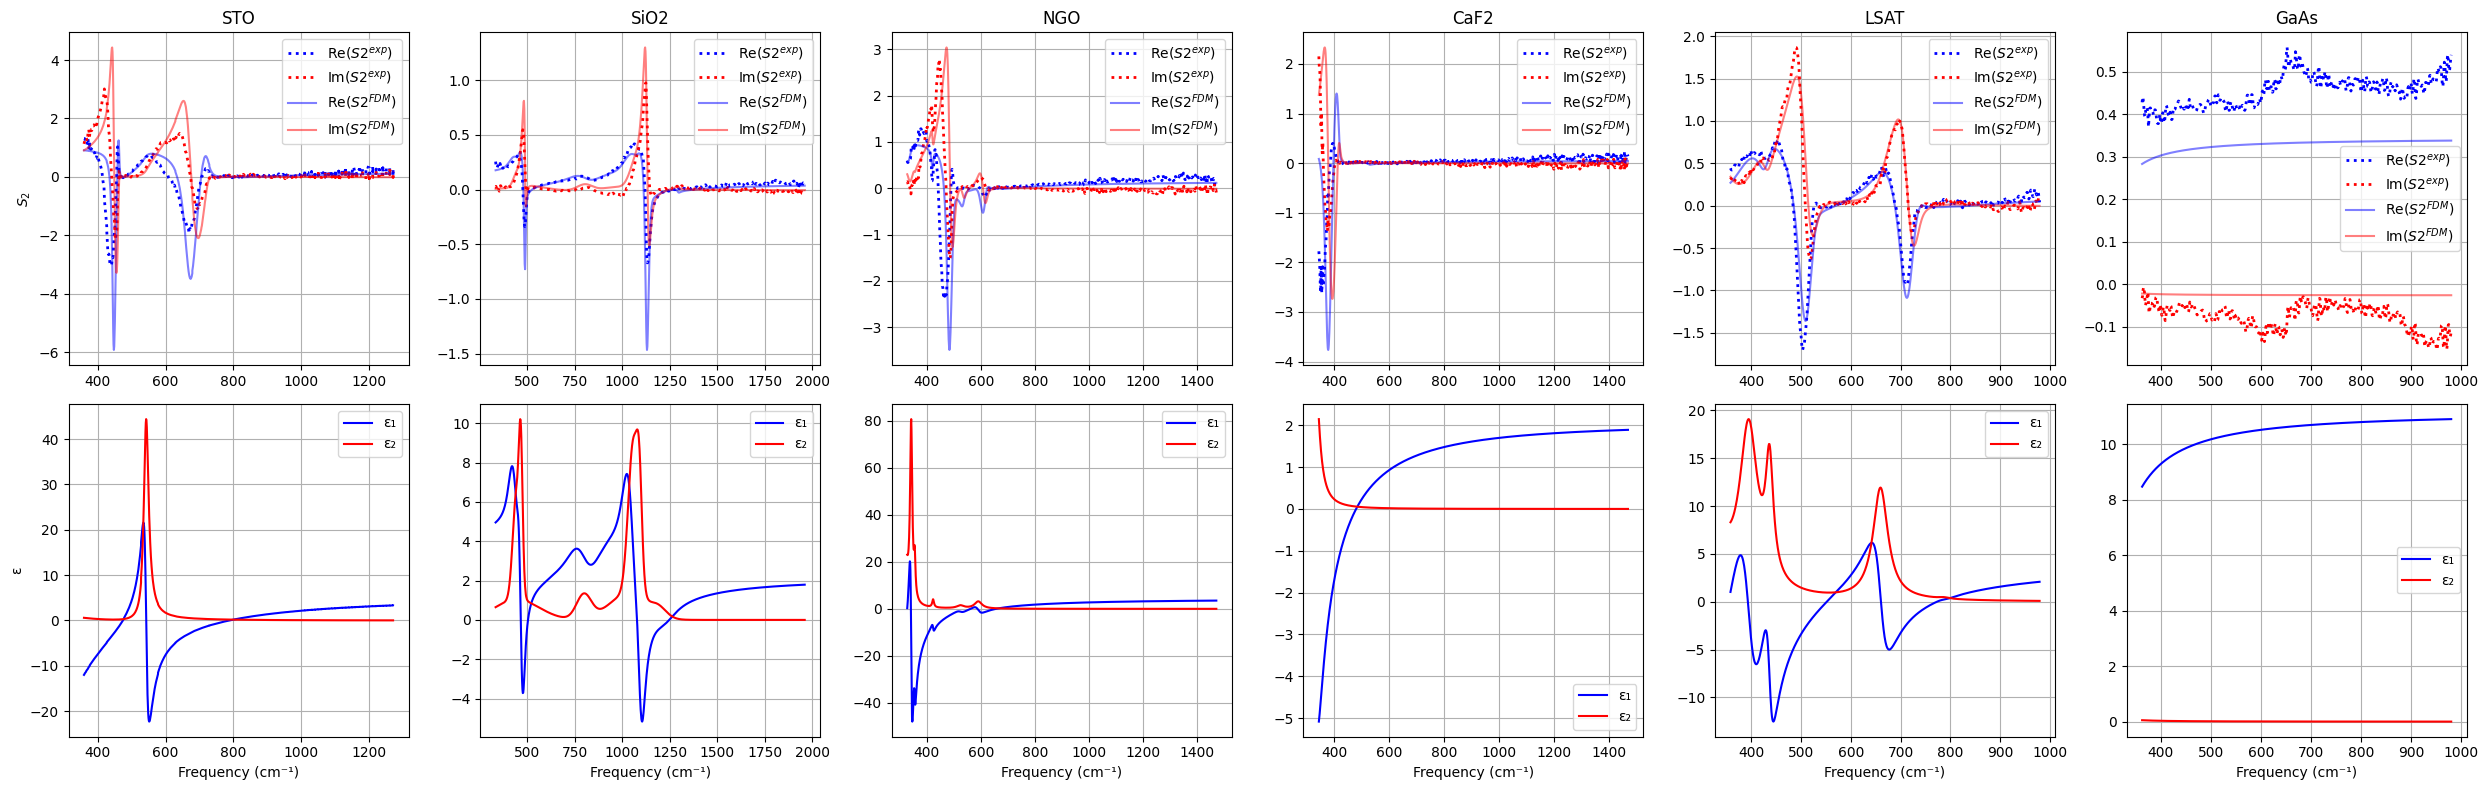

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=len(materials_list), figsize=(25,8))

for i, material in enumerate(materials_list):
    inner_dict = main_data_dict[material]
    f_material = inner_dict['f']
    eps_material = inner_dict['eps']  
    Sn_material = inner_dict['Sn_exp']
    normalized_integrated_values = inner_dict['Sn_fdm_normalized'] 
    
    # plot_epsilon(f_material, eps_material, material, '', ax[1, i])

    ax[0, i].set_title(f'{material}', )
    ax[0,i].plot(f_material, Sn_material.real, label= 'Re($S2^{exp}$)',color='b', linestyle='dotted', linewidth=2)
    ax[0,i].plot(f_material, Sn_material.imag, label= 'Im($S2^{exp}$)', color='r', linestyle='dotted', linewidth=2)

    ax[0,i].plot(f_material, normalized_integrated_values.real, label= 'Re($S2^{FDM}$)',color='b', alpha=0.5)
    ax[0,i].plot(f_material, normalized_integrated_values.imag, label= 'Im($S2^{FDM}$)', color='r', alpha=0.5)
    # ax[0,i].set_xlabel('Frequency (cm⁻¹)')
    if i == 0:
        ax[0,i].set_ylabel(f'$S_2$')
    ax[0,i].legend()
    ax[0,i].grid(True)
    
    ax[1, i].plot(f_material, eps_material.real, 'b-', label='ε₁')
    ax[1, i].plot(f_material, eps_material.imag, 'r-', label='ε₂')
    ax[1, i].set_xlabel('Frequency (cm⁻¹)')
    if i == 0:
        ax[1, i].set_ylabel('ε')
    ax[1, i].grid(True)
    ax[1, i].legend()


fig.tight_layout()


In [18]:

for i, main_data_split in enumerate(main_data_dict.items()):
    material, inner_dict = main_data_split
    if i == 0:
        main_eps = inner_dict['eps'].copy()
        main_Sn_exp = inner_dict['Sn_exp'].copy()
    else:
        main_eps = np.concatenate((main_eps, inner_dict['eps']), axis=0)
        main_Sn_exp = np.concatenate((main_Sn_exp, inner_dict['Sn_exp']), axis=0)


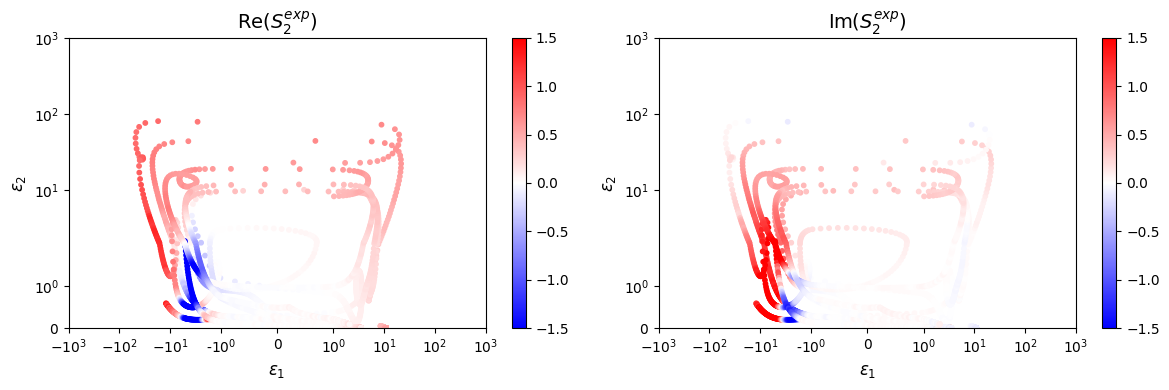

In [19]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

norm = mcolors.CenteredNorm(vcenter=0, halfrange = 1.5)  
sc1 = axes[0].scatter(main_eps.real, main_eps.imag, 
                      c=main_Sn_exp.real, cmap='bwr', norm=norm, marker='o', s=10,  label= 'Re($S2^{exp}$)')
axes[0].set_xlabel(r'$\epsilon_1$', fontsize=12)
axes[0].set_ylabel(r'$\epsilon_2$', fontsize=12)
axes[0].set_title(r'Re($S^{exp}_2$)', fontsize=14)

axes[0].set_xscale('symlog', linthresh=1)  # Symmetric log scale
axes[0].set_xticks([-10**3, -10**2, -10, -1, 0, 1, 10, 10**2, 10**3])  # Custom ticks
axes[0].set_xticklabels([r'$-10^3$', r'$-10^2$', r'$-10^1$', r'-$10^0$','0', r'$10^0$',r'$10^1$', r'$10^2$', r'$10^3$'])

axes[0].set_yscale('symlog', linthresh=2)  # Symmetric log scale
axes[0].set_yticks([0, 1,10, 10**2, 10**3])  # Custom ticks
axes[0].set_yticklabels([r'$0$', r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])
axes[0].set_ylim(bottom=0)

cb1 = plt.colorbar(sc1, ax=axes[0])

sc2 = axes[1].scatter(main_eps.real, main_eps.imag, 
                      c=main_Sn_exp.imag, cmap='bwr', norm = norm, marker='o', s=10,  label= 'Im($S2^{exp}$)')
axes[1].set_xlabel(r'$\epsilon_1$', fontsize=12)
axes[1].set_ylabel(r'$\epsilon_2$', fontsize=12)
axes[1].set_title(r'Im($S^{exp}_2$)', fontsize=14)

axes[1].set_xscale('symlog', linthresh=1)  # Symmetric log scale
axes[1].set_xticks([-10**3, -10**2, -10, -1, 0, 1, 10, 10**2, 10**3])  # Custom ticks
axes[1].set_xticklabels([r'$-10^3$', r'$-10^2$', r'$-10^1$', r'-$10^0$','0', r'$10^0$',r'$10^1$', r'$10^2$', r'$10^3$'])

axes[1].set_yscale('symlog', linthresh=2)  # Symmetric log scale
axes[1].set_yticks([0, 1,10, 10**2, 10**3])  # Custom ticks
axes[1].set_yticklabels([r'$0$', r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])
axes[1].set_ylim(bottom=0)
cb2 = plt.colorbar(sc2, ax=axes[1])

plt.tight_layout()
plt.show()

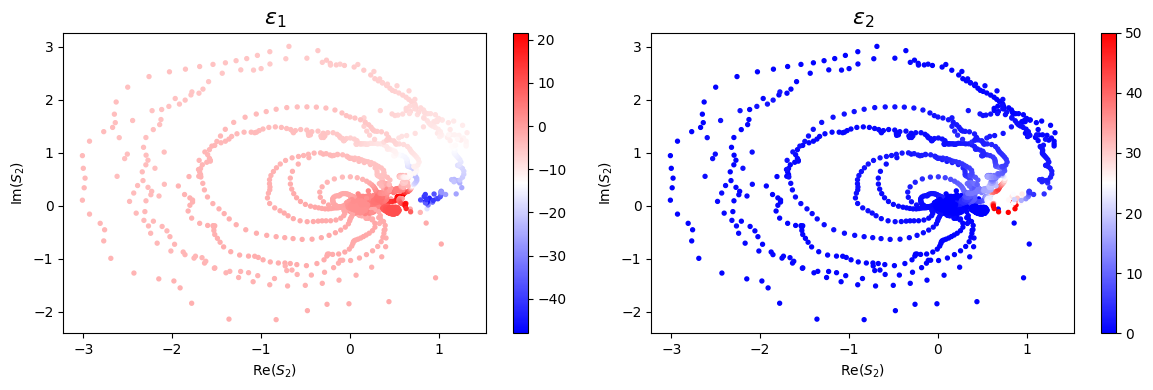

In [20]:
# Create a figure with two subplots.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sc1 = axes[0].scatter(main_Sn_exp.real, main_Sn_exp.imag, 
                      c=main_eps.real, cmap='bwr', marker='o', s = 8)
axes[0].set_xlabel(r'Re($S_2$)') 
axes[0].set_ylabel(r'Im($S_2$)') 
axes[0].set_title(r'$\epsilon_1$', fontsize=16)
cb1 = plt.colorbar(sc1, ax=axes[0])

norm = mcolors.CenteredNorm(vcenter=25, halfrange = 25)  
sc2 = axes[1].scatter(main_Sn_exp.real, main_Sn_exp.imag, 
                      c=main_eps.imag, cmap='bwr', marker='o', norm=norm, s=8)
axes[1].set_xlabel(r'Re($S_2$)') 
axes[1].set_ylabel(r'Im($S_2$)') 
axes[1].set_title(r'$\epsilon_2$', fontsize=16)
cb2 = plt.colorbar(sc2, ax=axes[1])

plt.tight_layout()
plt.show()

In [22]:
materials_list = ['STO', 'SiO2','NGO','CaF2', 'LSAT', 'GaAs']

main_data_dict = dict()

for i, material in enumerate(materials_list):
    inner_dict = dict()
    # material_path = rf'C:\nano_optics_ml_data\raw\{material}_eff.csv'
    material_path = chen_data_path / f'{material}_eff.csv'
    material_raw_data = np.genfromtxt(
        material_path,
        delimiter=','
        )
    eps_material = material_raw_data[:,0] + 1j*material_raw_data[:,1]
    Sn_material = material_raw_data[:,2] + 1j*material_raw_data[:,3]
    f_material = material_raw_data[:,4]
    if material == 'CaF2':
        eps_material = compute_permittivity(f_material, 'CaF2')

    integrated_values_material = compute_integrated_values(f_material, [2], 2*np.pi*250e3, eps_material)
    normalized_integrated_values = integrated_values_material/au_mean_S2

    inner_dict['eps1']  = eps_material.real
    inner_dict['eps2']  = eps_material.imag
    inner_dict['Sn_exp_real']  = Sn_material.real
    inner_dict['Sn_exp_imag']  = Sn_material.imag
    inner_dict['f']  = f_material
    inner_dict['Sn_fdm_norm_real']  = normalized_integrated_values.real
    inner_dict['Sn_fdm_norm_imag']  = normalized_integrated_values.imag
    
    main_data_dict[material] = inner_dict
    

In [23]:
import pandas as pd


# Convert dictionary to DataFrame
df_list = []
for material, values in main_data_dict.items():
    
    for key in values:
        values[key] = values[key].flatten()  # Ensure all arrays are 1D
    df = pd.DataFrame(values)
    df['material'] = material
    df_list.append(df)  # Store each as a separate DataFrame

# If you want to concatenate them into a single DataFrame with a MultiIndex:
final_df = pd.concat(df_list, ignore_index=True)

# Display the DataFrame


In [ ]:
final_df.to_csv(r'C:\nano_optics_ml_data\processed\article_main_data.csv')